In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [24]:
df = pd.read_csv('merged_car_sales_with_features.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55 entries, 2021-01-01 to 2025-08-01
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DAIHATSU                   55 non-null     float64
 1   HONDA                      55 non-null     float64
 2   MITSUBISHI                 55 non-null     float64
 3   SUZUKI                     55 non-null     float64
 4   TOYOTA                     55 non-null     float64
 5   bi_policy_rate_pct         55 non-null     object 
 6   inflation_yoy_pct          55 non-null     object 
 7   consumer_confidence_index  55 non-null     object 
 8   is_lebaran_season          55 non-null     int64  
 9   is_giias_month             55 non-null     int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 4.7+ KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA  \
count     55.000000     55.000000     55.000000     55.000000   

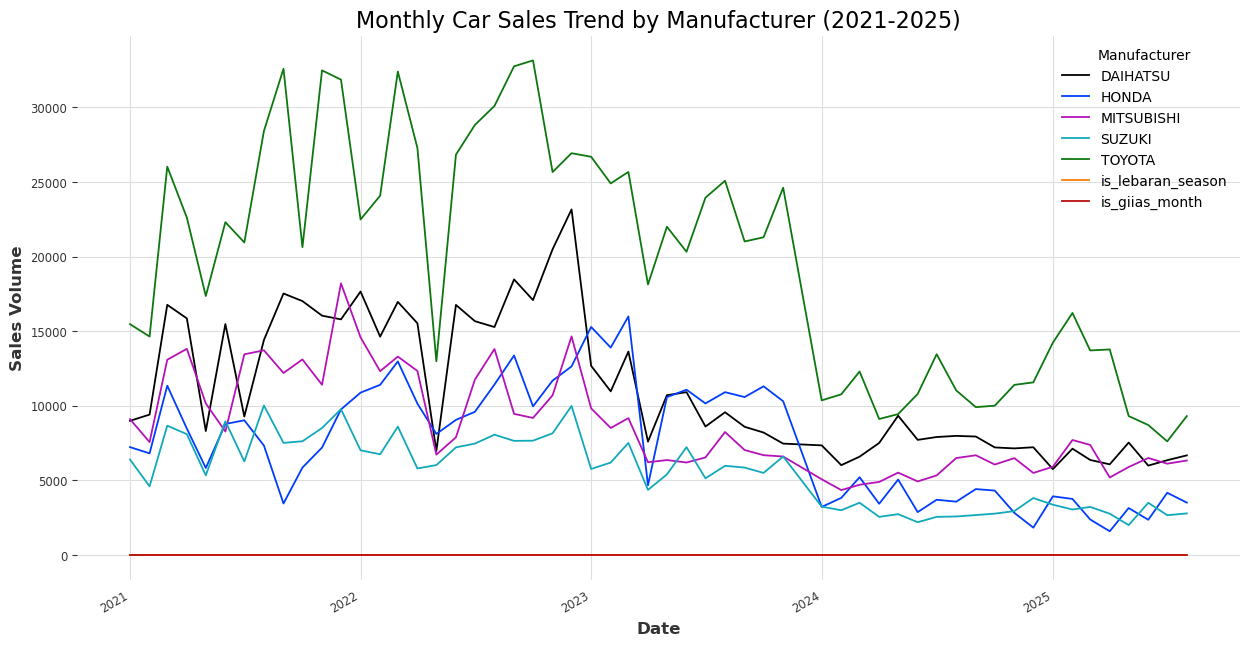

In [25]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [26]:
# # Calculate total sales to use as the target variable
# df['TOTAL_SALES'] = df.sum(axis=1)

# def create_features(df):
#     """Function to create time-series features from a datetime index."""
#     df['year'] = df.index.year
#     df['month'] = df.index.month
#     df['quarter'] = df.index.quarter
#     df['dayofyear'] = df.index.dayofyear
#     df['weekofyear'] = df.index.isocalendar().week.astype(int)

#     return df

# df = create_features(df)

# # Define features and the target
# FEATURES = ['year', 'month', 'quarter', 'dayofyear', 'weekofyear']
# TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

# for brand in TARGETS:
#     df[f'{brand}_lag1'] = df[brand].shift(1)
#     df[f'{brand}_lag3'] = df[brand].shift(3)
#     # df[f'{brand}_lag12'] = df[brand].shift(12)
    
#     # 移動平均特徴量 (過去3ヶ月と12ヶ月の平均)
#     df[f'{brand}_rolling_mean3'] = df[brand].shift(1).rolling(window=3).mean()
#     # df[f'{brand}_rolling_mean12'] = df[brand].shift(1).rolling(window=12).mean()
    
#     # 移動標準偏差 (過去3ヶ月)
#     df[f'{brand}_rolling_std3'] = df[brand].shift(1).rolling(window=3).std()
# df = df.dropna()

# X = df[FEATURES]
# y = df[TARGETS]



# print(df.head(20))


In [27]:
# --- 必要なライブラリとモデルのインポート ---
import pandas as pd
from darts import TimeSeries
from darts.metrics import smape

# 試したいモデルをDartsからインポート
from darts.models import (
    ARIMA,AutoARIMA,
    ExponentialSmoothing,
    Theta,
    FFT # Fast Fourier Transform
)

# --- 1. データの準備 (以前と同様) ---
target_brand = 'HONDA'
series = TimeSeries.from_series(df[target_brand], freq='MS')
train, val = series.split_before(pd.Timestamp('20250101'))


# --- 2. 試したいモデルのリストを作成 ---
# モデルの名前と、インスタンス化したモデルを辞書として定義
models_to_try = {
    "ARIMA": ARIMA(),
    "AutoARIMA": AutoARIMA(
        seasonal=True,             # 12ヶ月の季節性を考慮
        stepwise=True,
        # suppress_warnings=True
        ),
    "ExponentialSmoothing": ExponentialSmoothing(),
    "Theta": Theta(),
    "FFT": FFT()
}


# --- 3. ループですべてのモデルを学習・評価 ---
print("Evaluating various models...")
results = []
predictions = {} # ★ FIX: 予測結果を保存するための辞書を追加

for model_name, model in models_to_try.items():
    print(f"Fitting {model_name}...")
    try:
        model.fit(train)
        prediction = model.predict(len(val))
        smape_score = smape(val, prediction)
        
        results.append({
            "Model": model_name,
            "SMAPE (%)": smape_score
        })
        
        predictions[model_name] = prediction # ★ FIX: 予測を辞書に保存
        
        print(f"  - {model_name} SMAPE: {smape_score:.2f}%")
        
    except Exception as e:
        print(f"  - {model_name} failed with error: {e}")
        results.append({
            "Model": model_name,
            "SMAPE (%)": None
        })

# --- 4. 結果を比較する ---
df_results = pd.DataFrame(results)
print("\n--- Model Comparison Results ---")
print(df_results.sort_values(by="SMAPE (%)").reset_index(drop=True))


Evaluating various models...
Fitting ARIMA...
  - ARIMA SMAPE: 60.02%
Fitting AutoARIMA...
  - AutoARIMA SMAPE: 50.12%
Fitting ExponentialSmoothing...
  - ExponentialSmoothing SMAPE: nan%
Fitting Theta...
  - Theta failed with error: SVD did not converge in Linear Least Squares
Fitting FFT...
  - FFT SMAPE: 84.17%

--- Model Comparison Results ---
                  Model  SMAPE (%)
0             AutoARIMA  50.116261
1                 ARIMA  60.021662
2                   FFT  84.173966
3  ExponentialSmoothing        NaN
4                 Theta        NaN


c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



Visualizing forecasts...


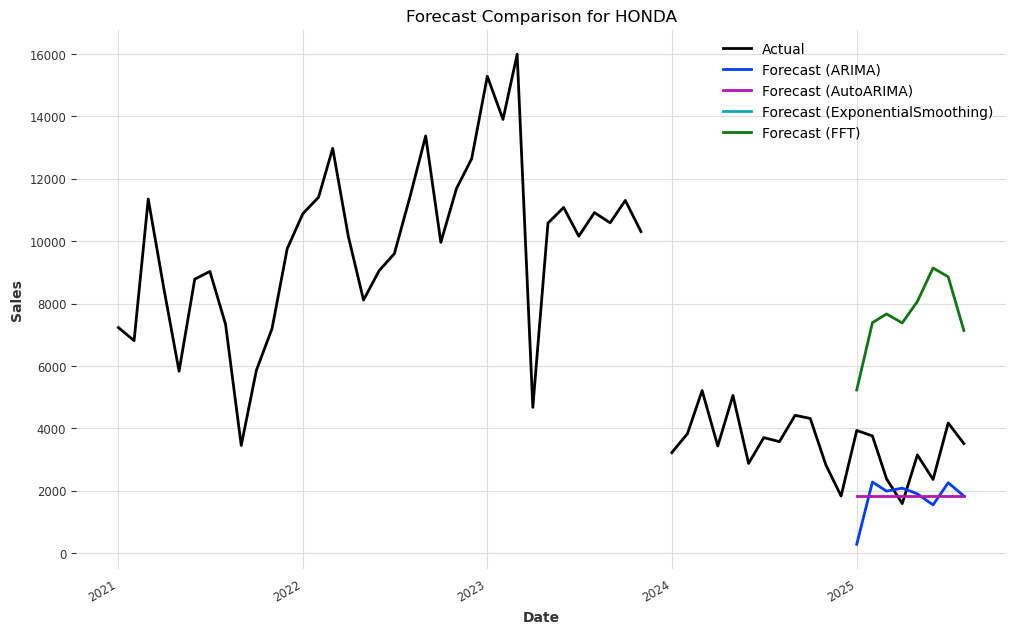

In [28]:
# --- 5. 予測結果をまとめて可視化 ---
print("\nVisualizing forecasts...")
plt.figure(figsize=(12, 7))

# 元の実績データをプロット
series.plot(label='Actual')

# 各モデルの予測をプロット
for model_name, pred in predictions.items():
    pred.plot(label=f'Forecast ({model_name})')

plt.title(f'Forecast Comparison for {target_brand}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [29]:
# --- 必要なライブラリとモデルのインポート ---
import pandas as pd
from darts import TimeSeries
from darts.metrics import smape
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 試したいモデルをDartsからインポート
from darts.models import (
    AutoARIMA,
    ExponentialSmoothing,
    Theta,
    FFT
)

# --- 0. 対象となる全てのブランドをリスト化 ---
TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

# 最終的な結果を保存するためのリスト
final_results = []

# --- 1. 全てのブランドに対してループ処理 ---
for target_brand in TARGETS:
    print(f"\n{'='*60}")
    print(f"Processing models for: {target_brand}")
    print(f"{'='*60}")

    # 1a. データの準備
    series = TimeSeries.from_series(df[target_brand], freq='MS')
    train, val = series.split_before(pd.Timestamp('20250101'))

    # 1b. 試したいモデルのリスト
    models_to_try = {
        "AutoARIMA": AutoARIMA(seasonal=True, stepwise=True),
        "ExponentialSmoothing": ExponentialSmoothing(),
        "Theta": Theta(),
        "FFT": FFT()
    }

    # 1c. ループで各モデルを評価
    results_for_brand = []
    for model_name, model in models_to_try.items():
        print(f"  - Fitting {model_name}...")
        try:
            model.fit(train)
            prediction = model.predict(len(val))
            smape_score = smape(val, prediction)
            
            results_for_brand.append({
                "Model": model_name,
                "SMAPE (%)": smape_score
            })
        except Exception as e:
            print(f"    - {model_name} failed with error.")
            results_for_brand.append({
                "Model": model_name,
                "SMAPE (%)": None
            })
    
    # 1d. このブランドで最も良かったモデルを見つける
    if not results_for_brand:
        continue
        
    df_results_brand = pd.DataFrame(results_for_brand).dropna()
    if df_results_brand.empty:
        continue

    best_model_info = df_results_brand.sort_values(by="SMAPE (%)").iloc[0]
    
    # 最終結果リストに追加
    final_results.append({
        "Brand": target_brand,
        "Best Model": best_model_info["Model"],
        "SMAPE (%)": best_model_info["SMAPE (%)"]
    })

# --- 2. 最終結果をまとめて表示 ---
print(f"\n{'='*60}")
print("--- FINAL SUMMARY: Best Model per Brand ---")
print(f"{'='*60}")

final_df = pd.DataFrame(final_results)
print(final_df.sort_values(by="SMAPE (%)").reset_index(drop=True))


Processing models for: DAIHATSU
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...
  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

Processing models for: HONDA
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...
  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

Processing models for: MITSUBISHI
  - Fitting AutoARIMA...


c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\uti

  - Fitting ExponentialSmoothing...
  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

Processing models for: SUZUKI
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...
  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

Processing models for: TOYOTA
  - Fitting AutoARIMA...
  - Fitting ExponentialSmoothing...
  - Fitting Theta...
    - Theta failed with error.
  - Fitting FFT...

--- FINAL SUMMARY: Best Model per Brand ---
        Brand Best Model  SMAPE (%)
0    DAIHATSU  AutoARIMA  12.150472
1  MITSUBISHI  AutoARIMA  15.507393
2      TOYOTA  AutoARIMA  25.147824
3      SUZUKI  AutoARIMA  27.724208
4       HONDA  AutoARIMA  50.116261


c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\utils.py:404: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1921: RuntimeWarning: Mean of empty slice
  return np.nanmean(
c:\Users\tohru\anaconda3\Lib\site-packages\darts\metrics\uti

In [35]:
# --- 必要なライブラリのインポート ---
from darts.models import ARIMA
from darts import TimeSeries
import pandas as pd
from darts.metrics import smape

# --- 1. データの読み込みと準備 (ここからが重要) ---
# 元の販売データを読み込む
sales_df = pd.read_csv('dataCarSale2021-2025.csv')
sales_df['waktu'] = pd.to_datetime(sales_df['waktu'])
sales_df = sales_df.set_index('waktu')

# 外部特徴量データを読み込む
features_df = pd.read_csv('extra_feature_engineering_withGeminii.csv', delimiter=';')
features_df.columns = features_df.columns.str.strip()
features_df['date'] = pd.to_datetime(features_df['waktu'])
features_df = features_df.set_index('date')

# 2つのデータフレームを結合
df_merged = sales_df.merge(features_df, left_index=True, right_index=True, how='left')

# --- 2. データのクレンジング ---
# カンマを小数点に置換し、データ型をfloatに変換
cols_to_clean = ['bi_policy_rate_pct', 'inflation_yoy_pct', 'consumer_confidence_index']
for col in cols_to_clean:
    df_merged[col] = df_merged[col].astype(str).str.replace(',', '.').astype(float)

# ★ FIX: 結合とクレンジングの後、NaNを含む行を削除
# これにより、2025年8月の空の行や、他の原因による欠損値がすべて削除される
df_clean = df_merged.dropna()

# (オプション) 欠損値がないことを確認
# print("Checking for missing values after cleaning:")
# print(df_clean.isnull().sum())

# --- 3. Darts TimeSeriesオブジェクトの作成 ---
TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']
covariate_cols = [
    'bi_policy_rate_pct', 'inflation_yoy_pct', 'consumer_confidence_index',
    'is_lebaran_season', 'is_giias_month'
]

arimax_results = []

for target_brand in TARGETS:
    print(f"\n--- Training ARIMAX for {target_brand} ---")
    
    # クレンジング済みのdf_cleanを使用
    series_target = TimeSeries.from_series(df_clean[target_brand], freq='MS')
    series_covariates = TimeSeries.from_dataframe(df_clean, value_cols=covariate_cols, freq='MS')

    # --- 4. 訓練データと検証データに分割 ---
    train_target, val_target = series_target.split_before(pd.Timestamp('20250101'))
    train_future_covariates, val_future_covariates = series_covariates.split_before(pd.Timestamp('20250101'))

    # --- 5. ARIMAXモデルの学習 ---
    model_arimax = ARIMA(p=1, d=1, q=1, seasonal_order=(0, 1, 1, 12))
    model_arimax.fit(train_target, future_covariates=train_future_covariates)

    # --- 6. 予測の実行 ---
    prediction = model_arimax.predict(
        n=len(val_target),
        future_covariates=series_covariates
    )

    # --- 7. 性能の評価 ---
    smape_score = smape(val_target, prediction)
    arimax_results.append({'Brand': target_brand, 'SMAPE (%)': smape_score})
    print(f"SMAPE for {target_brand} (ARIMAX): {smape_score:.2f}%")

# --- 結果の表示 ---
df_arimax_results = pd.DataFrame(arimax_results)
print("\n--- ARIMAX Model Evaluation ---")
print(df_arimax_results.sort_values(by="SMAPE (%)"))


--- Training ARIMAX for DAIHATSU ---


MissingDataError: exog contains inf or nans